In [4]:
!pip install pandas
!pip install openpyxl
!pip install psycopg2
!pip install psycopg2-binary
!pip install sqlalchemy



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: c:\users\olgap\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: c:\users\olgap\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: c:\users\olgap\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: c:\users\olgap\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: c:\users\olgap\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import psycopg2 as pg
from sqlalchemy import create_engine

## Загрузка данных.

In [3]:
# url = "https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIDS+SEP2023+type@asset+block@customer_and_transaction__2_.xlsx"
# transaction = pd.read_excel(url, sheet_name='transaction')
# customer = pd.read_excel(url, sheet_name='customer')

In [6]:
path = ".\customer_and_transaction.xlsx"
transaction = pd.read_excel(path, sheet_name='transaction')
customer = pd.read_excel(path, sheet_name='customer')

In [7]:
display(transaction.head())
display(customer.head())

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48


,customer_id,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,F,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,Eli,Bockman,Male,1980-12-16 00:00:00,Administrative Officer,Financial Services,Mass Customer,N,Yes,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,3,Arlin,Dearle,Male,1954-01-20 00:00:00,Recruiting Manager,Property,Mass Customer,N,Yes,0 Holy Cross Court,4211,QLD,Australia,9
3,4,Talbot,NaN,Male,1961-10-03 00:00:00,NaN,IT,Mass Customer,N,No,17979 Del Mar Point,2448,New South Wales,Australia,4
4,5,Sheila-kathryn,Calton,Female,1977-05-13 00:00:00,Senior Editor,NaN,Affluent Customer,N,Yes,9 Oakridge Court,3216,VIC,Australia,9


In [8]:
len(transaction['product_id'].unique())

101

В представленных таблицах можно выделить три ключевых элемента (сущности):
- Клиенты (`customer_id`)
- Продукты (`product_id`)
- Транзакции (`transaction_id`)

## Анализ и обработка данных.

In [9]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_id            4000 non-null   int64 
 1   first_name             4000 non-null   object
 2   last_name              3875 non-null   object
 3   gender                 4000 non-null   object
 4   DOB                    3913 non-null   object
 5   job_title              3494 non-null   object
 6   job_industry_category  3344 non-null   object
 7   wealth_segment         4000 non-null   object
 8   deceased_indicator     4000 non-null   object
 9   owns_car               4000 non-null   object
 10  address                4000 non-null   object
 11  postcode               4000 non-null   int64 
 12  state                  4000 non-null   object
 13  country                4000 non-null   object
 14  property_valuation     4000 non-null   int64 
dtypes: int64(3), object(1

Основные пропуски в данных типа `object` заменим на `unknown`, удалим записи с отсутствующей датой рождения для простоты дальнейшей обработки данных.

In [ ]:
customer = customer.dropna(subset=['DOB'])
customer['DOB'] = pd.to_datetime(customer['DOB'], errors='coerce')
customer.fillna('Unknown', inplace=True)
customer['owns_car'] = customer['owns_car'].map({'Yes': True, 'No': False})

In [ ]:
print(customer['gender'].unique())
print(customer['wealth_segment'].unique())
print(customer['deceased_indicator'].unique())
print(customer['state'].unique())
print(customer['country'].unique())

['F' 'Male' 'Female' 'U' 'Femal' 'M']
['Mass Customer' 'Affluent Customer' 'High Net Worth']
['N' 'Y']
['New South Wales' 'QLD' 'VIC' 'NSW' 'Victoria']
['Australia']


В данных есть некоторая несогласованность, которую нужно поправить.

In [ ]:
customer['gender'] = customer['gender'].apply(lambda x: x[0])
customer['state'] = customer['state'].replace('New South Wales', 'NSW')
customer['state'] = customer['state'].replace('Victoria', 'VIC')

In [ ]:
customer.duplicated().sum()

np.int64(0)

In [ ]:
customer[customer['customer_id'].duplicated()]

,customer_id,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,postcode,state,country,property_valuation


Разделим таблицу `transactions` на сущности:
- Транзакции
- Продукты

In [ ]:
products = transaction[['product_id', 'brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost']]
transactions = transaction.drop(columns=['brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost'])

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     20000 non-null  int64  
 1   brand          19803 non-null  object 
 2   product_line   19803 non-null  object 
 3   product_class  19803 non-null  object 
 4   product_size   19803 non-null  object 
 5   list_price     20000 non-null  float64
 6   standard_cost  19803 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ MB


In [ ]:
products.head()

,product_id,brand,product_line,product_class,product_size,list_price,standard_cost
0,2,Solex,Standard,medium,medium,71.49,53.62
1,3,Trek Bicycles,Standard,medium,large,2091.47,388.92
2,37,OHM Cycles,Standard,low,medium,1793.43,248.82
3,88,Norco Bicycles,Standard,medium,medium,1198.46,381.10
4,78,Giant Bicycles,Standard,medium,large,1765.30,709.48


In [ ]:
len(products['product_id'].unique())

101

In [ ]:
products.dropna(inplace=True)
products.drop_duplicates(inplace=True)

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 0 to 17468
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     203 non-null    int64  
 1   brand          203 non-null    object 
 2   product_line   203 non-null    object 
 3   product_class  203 non-null    object 
 4   product_size   203 non-null    object 
 5   list_price     203 non-null    float64
 6   standard_cost  203 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 12.7+ KB


In [ ]:
products[products['product_id'].duplicated()]

,product_id,brand,product_line,product_class,product_size,list_price,standard_cost
14,12,Giant Bicycles,Standard,medium,large,1765.30,709.480000
41,79,Solex,Touring,medium,large,2083.94,675.030000
54,0,Norco Bicycles,Standard,low,medium,363.01,290.410000
57,91,Solex,Standard,medium,medium,100.35,75.260000
60,0,OHM Cycles,Road,high,large,12.01,7.210000
...,...,...,...,...,...,...,...
1835,70,Norco Bicycles,Road,medium,medium,1036.59,206.350000
2166,0,Solex,Standard,medium,medium,441.49,84.990000
8707,0,Solex,Road,medium,medium,416.98,312.735016
16700,0,Norco Bicycles,Standard,medium,medium,360.40,270.299988


В связи с тем, что овсновная тема домашнего задания состоит в работе с POSTGRES базой данных, а не обработка данных, я просто удаляю дубликаты `product_id`

In [ ]:
products = products.drop_duplicates(subset=['product_id'], keep='first')

In [ ]:
len(products)

101

In [ ]:
print(products['brand'].unique())
print(products['product_line'].unique())
print(products['product_class'].unique())
print(products['product_size'].unique())

['Solex' 'Trek Bicycles' 'OHM Cycles' 'Norco Bicycles' 'Giant Bicycles'
 'WeareA2B']
['Standard' 'Road' 'Mountain' 'Touring']
['medium' 'low' 'high']
['medium' 'large' 'small']


In [ ]:
transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status
0,1,2,2950,2017-02-25,False,Approved
1,2,3,3120,2017-05-21,True,Approved
2,3,37,402,2017-10-16,False,Approved
3,4,88,3135,2017-08-31,False,Approved
4,5,78,787,2017-10-01,True,Approved


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    20000 non-null  int64         
 1   product_id        20000 non-null  int64         
 2   customer_id       20000 non-null  int64         
 3   transaction_date  20000 non-null  datetime64[ns]
 4   online_order      19640 non-null  object        
 5   order_status      20000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 937.6+ KB


In [ ]:
print(transactions['online_order'].unique())
print(transactions['order_status'].unique())

[False True nan]
['Approved' 'Cancelled']


In [ ]:
transactions = transactions.dropna(subset=['online_order'])

In [ ]:
transactions['online_order'] = transactions['online_order'].astype(bool)

In [ ]:
transactions.duplicated().sum()

np.int64(0)

In [ ]:
transactions[transactions['transaction_id'].duplicated()]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status


## Получаем три таблицы по сущностям

In [30]:
display(customer.head())
display(products.head())
display(transactions.head())

,customer_id,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,F,1953-10-12,Executive Secretary,Health,Mass Customer,N,True,060 Morning Avenue,2016,NSW,Australia,10
1,2,Eli,Bockman,M,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,True,6 Meadow Vale Court,2153,NSW,Australia,10
2,3,Arlin,Dearle,M,1954-01-20,Recruiting Manager,Property,Mass Customer,N,True,0 Holy Cross Court,4211,QLD,Australia,9
3,4,Talbot,Unknown,M,1961-10-03,Unknown,IT,Mass Customer,N,False,17979 Del Mar Point,2448,NSW,Australia,4
4,5,Sheila-kathryn,Calton,F,1977-05-13,Senior Editor,Unknown,Affluent Customer,N,True,9 Oakridge Court,3216,VIC,Australia,9


,product_id,brand,product_line,product_class,product_size,list_price,standard_cost
0,2,Solex,Standard,medium,medium,71.49,53.62
1,3,Trek Bicycles,Standard,medium,large,2091.47,388.92
2,37,OHM Cycles,Standard,low,medium,1793.43,248.82
3,88,Norco Bicycles,Standard,medium,medium,1198.46,381.10
4,78,Giant Bicycles,Standard,medium,large,1765.30,709.48


,transaction_id,product_id,customer_id,transaction_date,online_order,order_status
0,1,2,2950,2017-02-25,False,Approved
1,2,3,3120,2017-05-21,True,Approved
2,3,37,402,2017-10-16,False,Approved
3,4,88,3135,2017-08-31,False,Approved
4,5,78,787,2017-10-01,True,Approved


Далее для приведения всех данных к 3НФ, выделим `location` из таблицы `customer` так ак данные по локации не зависят напрямую от `Id` клиента, а от почтового индекса. Тем самым мы избавимся от дублирования данных.

In [31]:
locations = customer[['postcode', 'state', 'country']]
customer = customer.drop(columns=['state', 'country'])

In [32]:
locations = locations.drop_duplicates()

In [33]:
display(locations.head())
display(customer.head())

,postcode,state,country
0,2016,NSW,Australia
1,2153,NSW,Australia
2,4211,QLD,Australia
3,2448,NSW,Australia
4,3216,VIC,Australia


,customer_id,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,postcode,property_valuation
0,1,Laraine,Medendorp,F,1953-10-12,Executive Secretary,Health,Mass Customer,N,True,060 Morning Avenue,2016,10
1,2,Eli,Bockman,M,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,True,6 Meadow Vale Court,2153,10
2,3,Arlin,Dearle,M,1954-01-20,Recruiting Manager,Property,Mass Customer,N,True,0 Holy Cross Court,4211,9
3,4,Talbot,Unknown,M,1961-10-03,Unknown,IT,Mass Customer,N,False,17979 Del Mar Point,2448,4
4,5,Sheila-kathryn,Calton,F,1977-05-13,Senior Editor,Unknown,Affluent Customer,N,True,9 Oakridge Court,3216,9


In [34]:
locations[locations['postcode'].duplicated()]

,postcode,state,country


In [35]:
print(locations.info())
print(customer.info())

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   postcode  871 non-null    int64 
 1   state     871 non-null    object
 2   country   871 non-null    object
dtypes: int64(1), object(2)
memory usage: 27.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 3913 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            3913 non-null   int64         
 1   first_name             3913 non-null   object        
 2   last_name              3913 non-null   object        
 3   gender                 3913 non-null   object        
 4   DOB                    3913 non-null   datetime64[ns]
 5   job_title              3913 non-null   object        
 6   job_industry_category  3913 non-null   object        
 7   wealth_segment  

## **Почему исходные данные не были в 3НФ?**

- **Дублирование данных** – информация о продуктах повторялась в `transactions`, а информация о местах – в `customers`.
- **Транзитивные зависимости** – `state` и `country` зависели от `postcode`, а не от `customer_id`.
- **Некорректные зависимости атрибутов** – данные о продуктах зависели от `product_id`, но хранились в `transactions`.

# **Отчет о нормализации данных**

## **1. Исходная структура данных**
Первоначальный датасет содержал информацию о клиентах и транзакциях в виде двух больших таблиц с избыточностью данных. Основные проблемы:

- **Дублирование информации о продуктах** в таблице транзакций (например, `brand`, `product_line`, `product_class`, `product_size`, `list_price`, `standard_cost`).
- **Транзитивная зависимость** между `postcode`, `state`, `country` в таблице клиентов.
- **Отсутствие четкой структуры связи** между клиентами, транзакциями и продуктами.

## **2. Шаги нормализации**
### **Шаг 1: Выделение таблицы `products` (из 1НФ в 2НФ)**
- В таблице **`transactions`** повторялась информация о продуктах.
- Создана **отдельная таблица `products`**, содержащая уникальные товары.
- В таблице **`transactions`** теперь хранится **только `product_id`**, а вся информация о продуктах хранится в `products`.

### **Шаг 2: Выделение таблицы `locations` (из 2НФ в 3НФ)**
- В таблице **`customers`** наблюдалась **транзитивная зависимость**:
- Создана **отдельная таблица `locations`**, где каждому `postcode` соответствует `state` и `country`.
- В таблице **`customers`** теперь хранится **только `postcode`**, который ссылается на `locations`.

### **Шаг 3: Оптимизация `customers`**
- Убраны избыточные столбцы `state` и `country`, оставлен `postcode` как внешний ключ.
- Поле **`property_valuation` оставлено в `customers`**, так как оно относится к конкретному клиенту.

### **Шаг 4: Оптимизация `transactions`**
- В таблице **`transactions`** теперь есть **только необходимые связи** (`customer_id` и `product_id`).

## **3. Итоговая нормализованная структура (3НФ)**
Теперь база данных состоит из **четырех взаимосвязанных таблиц**:

- **`customers`** – данные о клиентах.
- **`transactions`** – данные о транзакциях (ссылки на `customers` и `products`).
- **`products`** – данные о товарах.
- **`locations`** – информация о географическом положении клиентов.

**Все транзитивные зависимости устранены**, а избыточные данные вынесены в отдельные таблицы.


## Схема таблиц в базе данных


```

Table locations {
  postcode int [primary key]
  state text
  country text
}

Table customer {
  customer_id int [primary key]
  first_name text
  last_name text
  gender text
  DOB date
  job_title text
  job_industry_category text
  wealth_segment text
  deceased_indicator boolean
  owns_car boolean
  address text
  postcode int [ref: > locations.postcode]
  property_valuation int
}

Table products {
  product_id int [primary key]
  brand text
  product_line text
  product_class text
  product_size text
  list_price decimal(10,2)
  standard_cost decimal(10,2)
}

Table transactions {
  transaction_id int [primary key]
  product_id int [ref: > products.product_id]
  customer_id int [ref: > customer.customer_id]
  transaction_date date
  online_order boolean
  order_status text
}
```




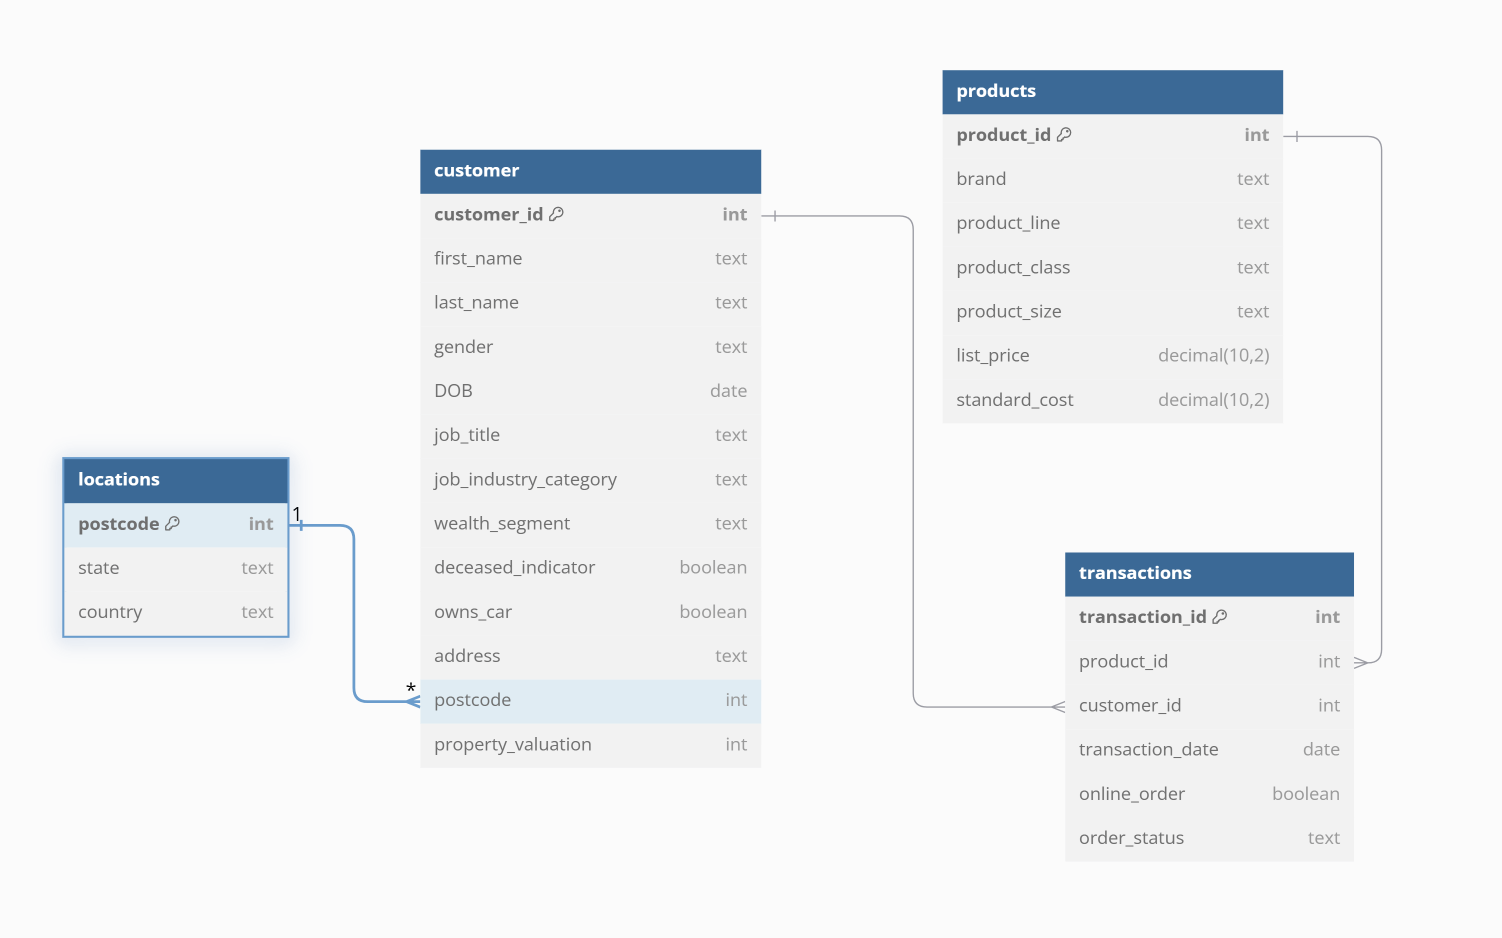

In [10]:
DB_NAME = "postgres"
USER = "postgres"
PASSWORD = "postgres"
HOST = "localhost"
PORT = "5432"

In [11]:
conn = pg.connect(dbname=DB_NAME , host=HOST, user=USER, password=PASSWORD, port=PORT)
cursor = conn.cursor()

In [12]:
conn.rollback()

In [13]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS locations (
        postcode INT PRIMARY KEY,
        state TEXT,
        country TEXT
    );
""")

In [14]:
cursor.execute(
    '''
    CREATE TABLE IF NOT EXISTS customer(
    customer_id INT PRIMARY KEY,
    first_name TEXT,
    last_name TEXT,
    gender TEXT,
    DOB DATE,
    job_title TEXT,
    job_industry_category TEXT,
    wealth_segment TEXT,
    deceased_indicator BOOLEAN,
    owns_car BOOLEAN,
    address TEXT,
    postcode INT REFERENCES locations(postcode),
    property_valuation INT
    )
    '''
)

In [15]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS products (
        product_id INT PRIMARY KEY,
        brand TEXT,
        product_line TEXT,
        product_class TEXT,
        product_size TEXT,
        list_price DECIMAL(10,2),
        standard_cost DECIMAL(10,2)
    );
""")

In [16]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS transactions (
        transaction_id INT PRIMARY KEY,
        product_id INT REFERENCES products(product_id),
        customer_id INT REFERENCES customer(customer_id),
        transaction_date DATE,
        online_order BOOLEAN,
        order_status TEXT
    );
""")

In [17]:
conn.commit()

In [18]:
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}')

In [ ]:
products.to_sql('products', con=engine, if_exists='append', index=False)

# existing_product_ids = pd.read_sql("SELECT product_id FROM products", con=engine)
# products = products[~products['product_id'].isin(existing_product_ids['product_id'])]
# products.to_sql('products', con=engine, if_exists='append', index=False)

# products.to_sql('products', con=engine, if_exists='replace', index=False)

In [ ]:
locations.to_sql('locations', con=engine, if_exists='append', index=False)

871

In [ ]:
customer.columns = customer.columns.str.lower()

In [ ]:
customer.to_sql('customer', con=engine, if_exists='append', index=False)

913

In [ ]:
missing_customers = transactions[~transactions['customer_id'].isin(customer['customer_id'])]
print(missing_customers['customer_id'].unique())

transactions = transactions[transactions['customer_id'].isin(customer['customer_id'])]
print(len(transactions))

[2426 3473 2000 1038 3151 1477 2999  599 2252 2920 1683  892  290 1509
 2069 1210  513 3086 2341 1082  451  983 3365  685 1918 3255 2540 2205
 2469 1244  453  883 1806  168  480  454 3343 1740 1583  680 2854  950
 2696 2647 3312 1773 2697  799  548 3012 1351 1628 3288 1780 3298 1174
  839  144 2295 2642 3322 3223  975 1990  267 2165 3222 1044 2335 5034
 1938 2414  526  996  582 2963 2021]
19199


In [ ]:
transactions.to_sql('transactions', con=engine, if_exists='append', index=False)

199

In [ ]:
conn.commit()

In [ ]:
cursor.close()
conn.close()

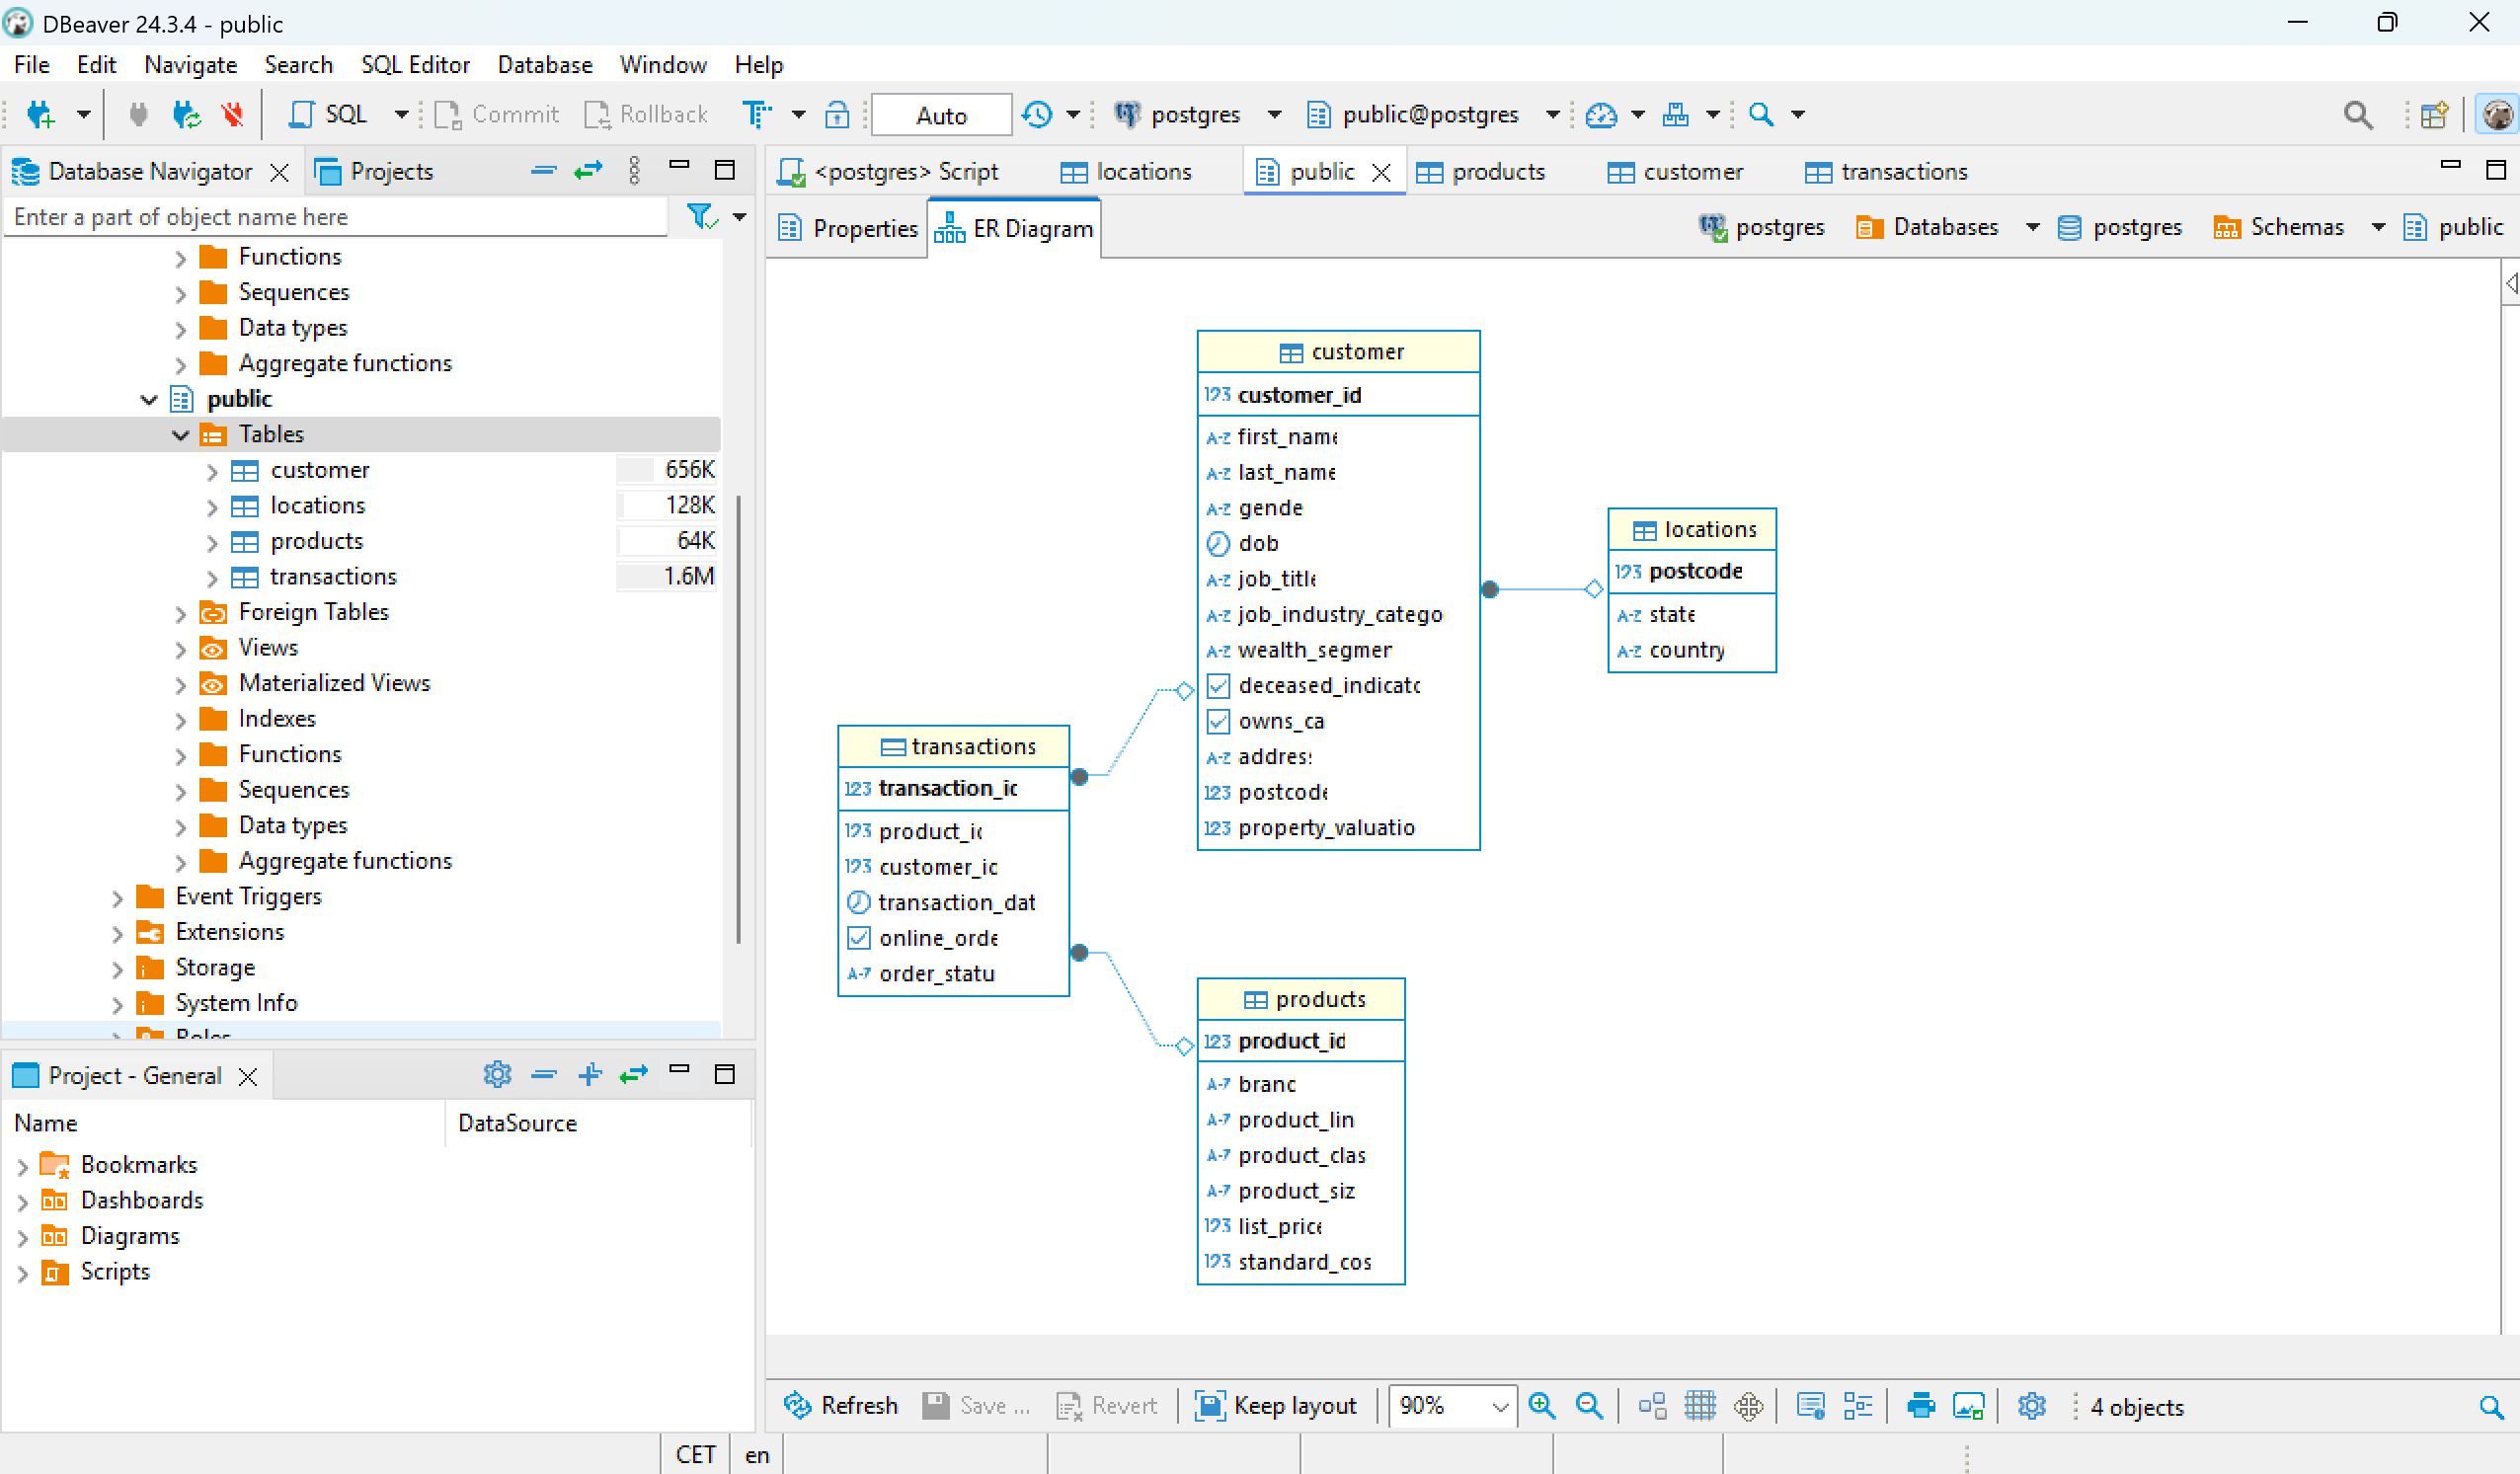

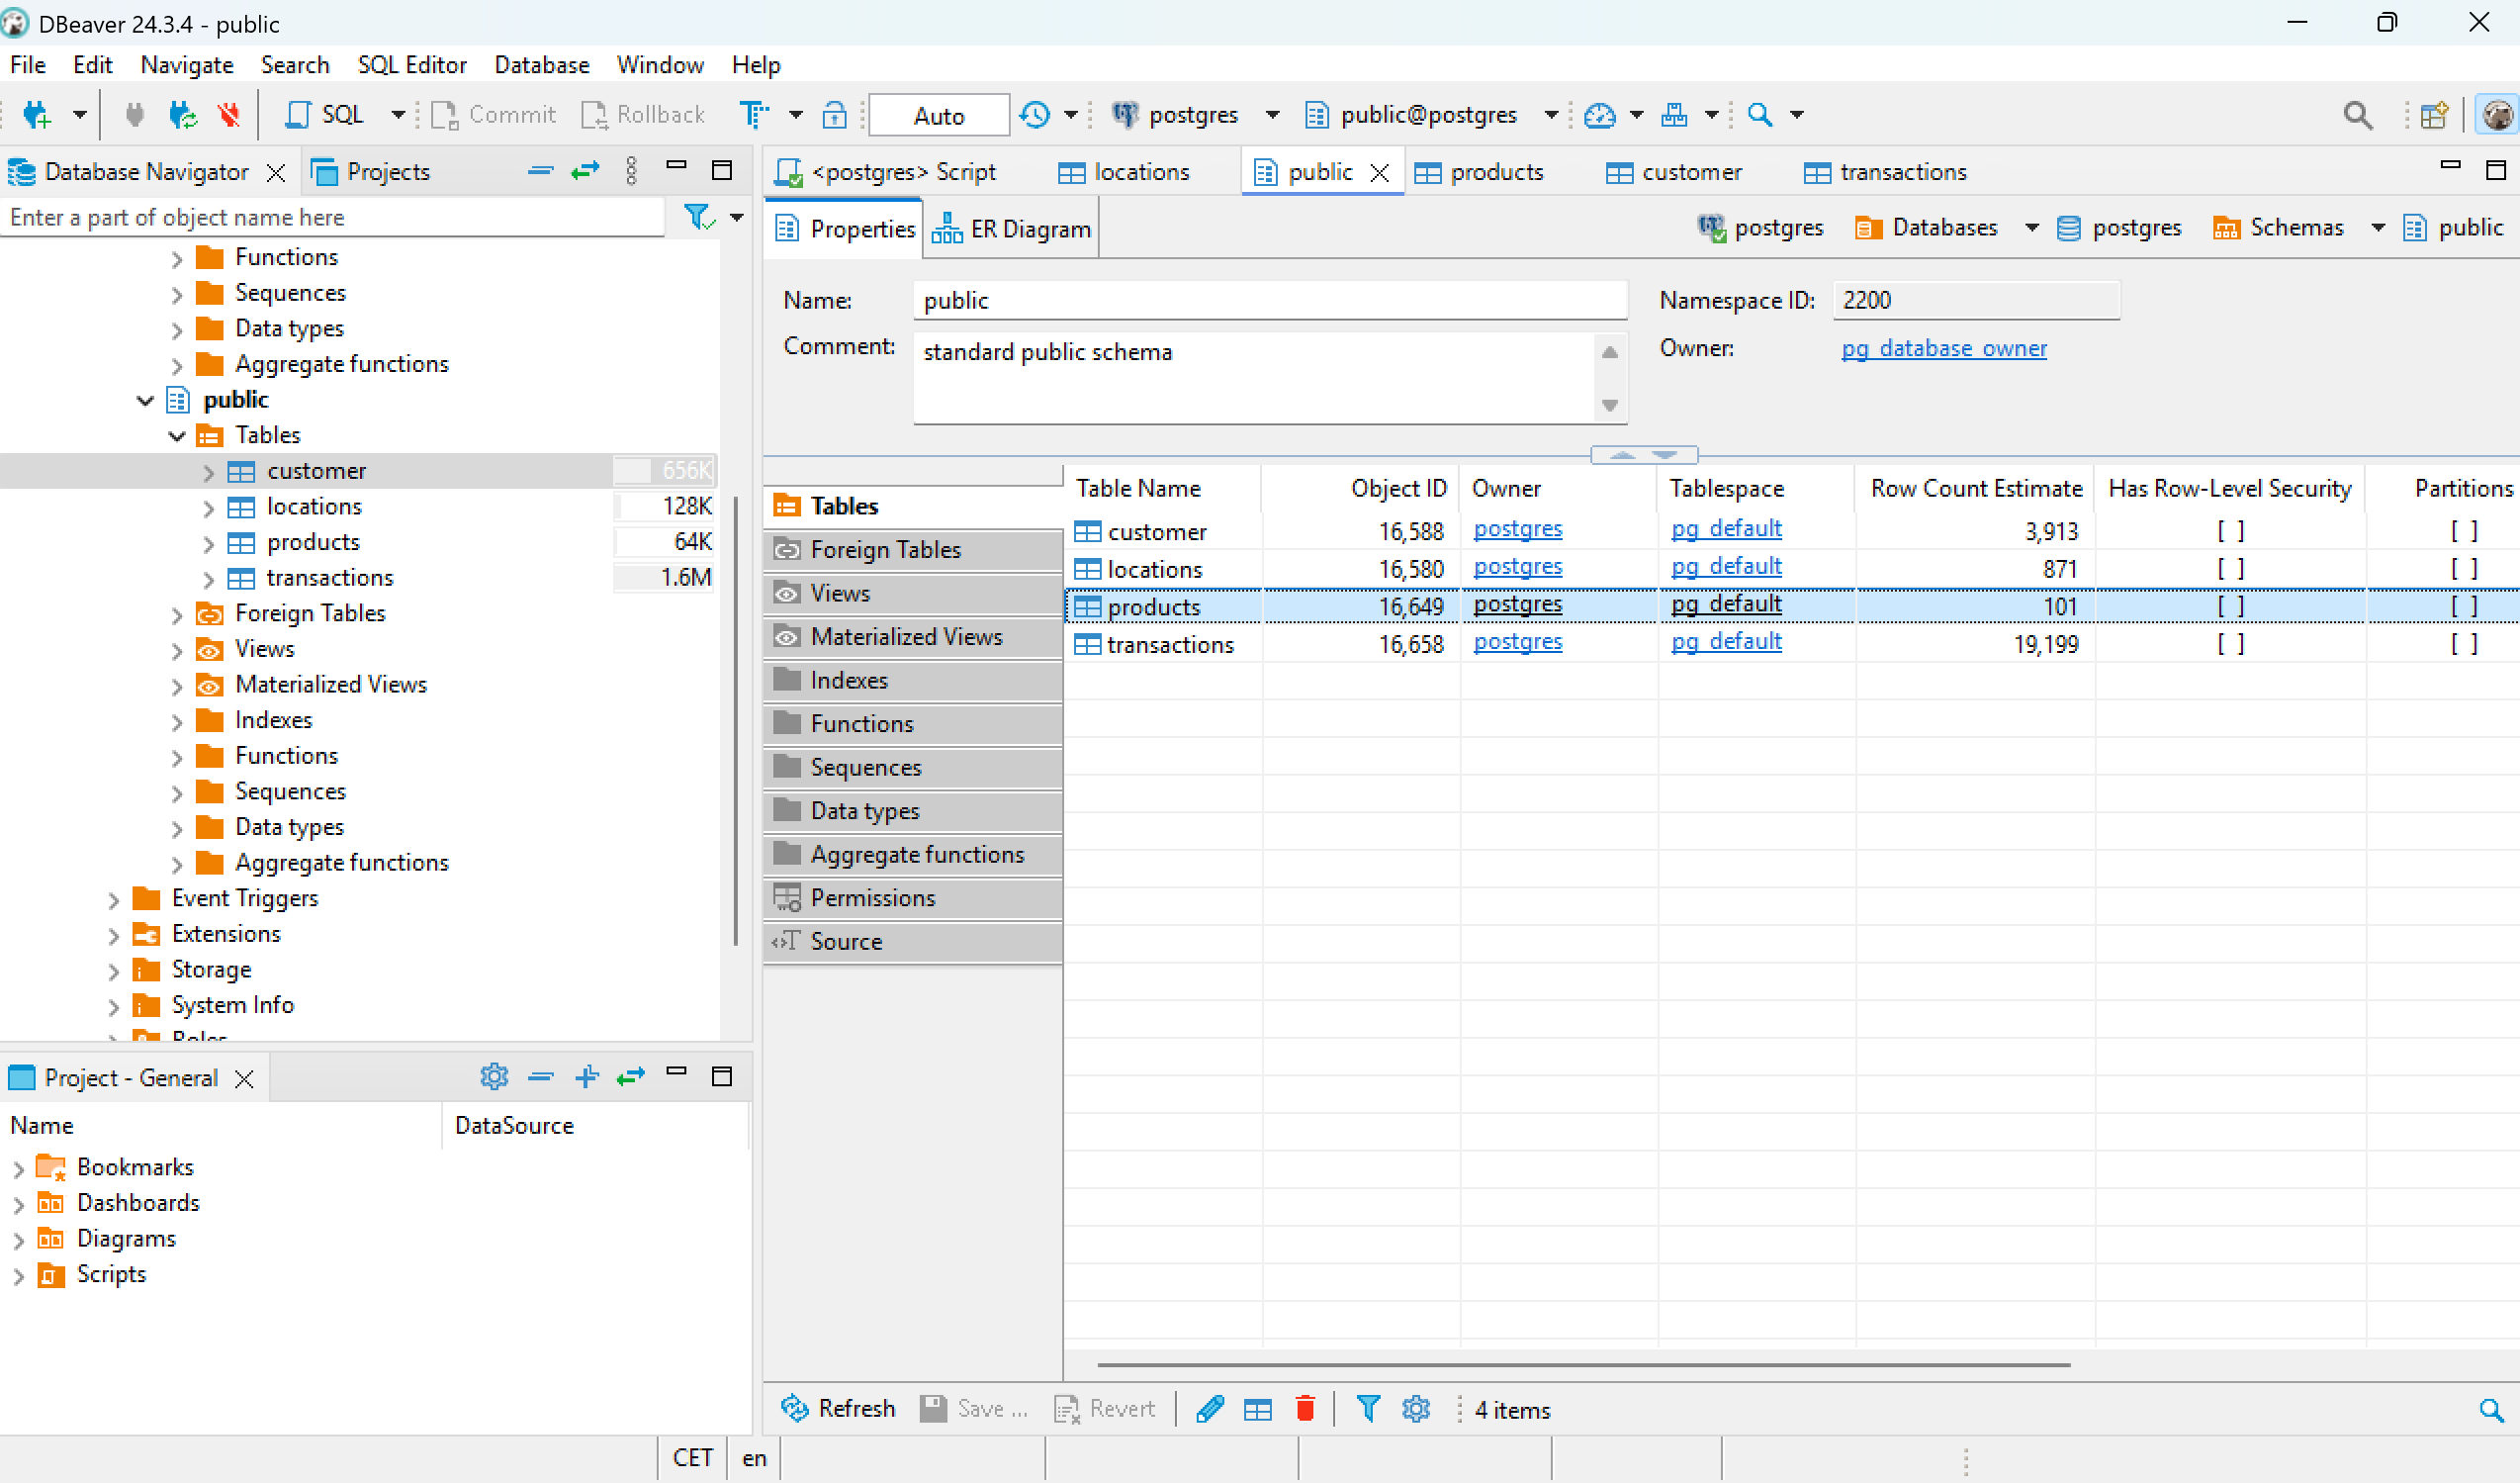

В связи с тем, что основной темой работы является работа с POSTGRES, я достаточно привольно удаляю дубликаты, несуществующие `id` и прочее.